# Importing Libraries

In [ ]:
#pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Import Data

In [ ]:
import cv2 as cv
import os
import zipfile
import numpy as np
import pandas as pd
import gdown

classes={
    0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),

    1:('bcc' , 'basal cell carcinoma'),

    2:('bkl', 'benign keratosis-like lesions'),

    3:('df', 'dermatofibroma'),

    4:('nv', ' melanocytic nevi'),

    5:('vasc', ' pyogenic granulomas and hemorrhage'),

    6:('mel', 'melanoma'),
    }


def create_dataset(resize=None):
    def process_images(srcdir,resize=None):
        imgs = []
        filenames = []

        for dir in srcdir:
            dir = download_file(dir)
            with zipfile.ZipFile(dir, 'r') as zipf:
                for temp in zipf.namelist():
                    img = cv.imdecode(np.frombuffer(zipf.read(temp), np.uint8), cv.IMREAD_COLOR)
                    if resize is not None:
                        img = cv.resize(img, resize)
                    imgs.append(img)
                    filenames.append(temp)

        # Split filenames to remove file extensions
        filenames = [os.path.splitext(filename)[0] for filename in filenames]

        return imgs, filenames

    def merge_with_meta(imgs,meta,filenames):
        # Create the DataFrame with flattened pixel values
        dt = pd.DataFrame([img.flatten() for img in imgs])
        dt.columns = ['pixel'+str(i) for i in range(dt.shape[1])]
        dt['image_id'] = filenames

        dd = pd.read_csv(meta)
        dt=dt.merge(dd[['image_id','dx']], on='image_id', how='left')
        dt['label'] = dt['dx'].map({value[0]:key for key, value in classes.items()})

        dt = dt.drop(['image_id','dx'], axis=1)
        return dt,dd

    #https://www.intodeeplearning.com/how-to-download-files-or-folders-in-gdrive-in-python/
    def download_file(url):
        output_path = 'file.zip'
        gdown.download(url, output_path, quiet=False,fuzzy=True)
        return output_path


    # Process the images and filenames
    srcdir = ['1vNLwZ4ao7eZTAeH0JRIhaZ1QbiP3LsDG','1w6eRHc4sKJ1jzh5gU112HK8mfgraqcIj']
    srcdir = ['https://drive.google.com/uc?id=' + x for x in srcdir]
    meta ='https://drive.google.com/uc?id=' + '1x5hrResjvpGAu-xVkJJH-hT1q4wx6xco'
    imgs, filenames = process_images(srcdir, resize=resize)
    train,train_meta = merge_with_meta(imgs,meta,filenames)

    # Process the images and filenames
    srcdir = ['1n71CVP_3-OpcwSaC6z1Y1JCyCznzVP9t']
    srcdir = ['https://drive.google.com/uc?id=' + x for x in srcdir]
    meta ='https://drive.google.com/uc?id=' + '1gONzrx2LBFRpIsajIc12yEnOA-axPSyt'
    imgs, filenames = process_images(srcdir, resize=resize)
    test,test_meta = merge_with_meta(imgs,meta,filenames)

    return train,test,train_meta,test_meta


def get_default_dataset():
    train = pd.read_csv('https://drive.google.com/uc?id=' + '12tVAC3jbVNUbaQUlchV5-8ZYZXqOzfMr')
    test = pd.read_csv('https://drive.google.com/uc?id=' + '1kYWB6TAoQbaZHtQycE1Jue0lUKc62IV7')
    train_meta = pd.read_csv('https://drive.google.com/uc?id=' + '1x5hrResjvpGAu-xVkJJH-hT1q4wx6xco')
    test_meta = pd.read_csv('https://drive.google.com/uc?id=' + '1gONzrx2LBFRpIsajIc12yEnOA-axPSyt')
    return train,test,train_meta,test_meta


In [ ]:
#from ham import create_dataset,get_default_dataset,classes

height,width = 32,32 # Only change this line if using a different image size
channel = 3
input_shape = (height, width, channel)
reshape = (-1,height,width,channel)

In [ ]:
if height == width == 28:
    # Use default dataset
    data,testset,data_meta,testset_meta = get_default_dataset()
else:
    # Generate the dataset (if using a different shape) - runs for 5 mins
    data,testset,data_meta,testset_meta  = create_dataset(resize=(height, width))


Downloading...
From: https://drive.google.com/uc?id=1vNLwZ4ao7eZTAeH0JRIhaZ1QbiP3LsDG
To: /content/file.zip
100%|██████████| 1.37G/1.37G [00:13<00:00, 105MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1w6eRHc4sKJ1jzh5gU112HK8mfgraqcIj
To: /content/file.zip
100%|██████████| 1.40G/1.40G [00:12<00:00, 117MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1n71CVP_3-OpcwSaC6z1Y1JCyCznzVP9t
To: /content/file.zip
100%|██████████| 420M/420M [00:05<00:00, 80.5MB/s]


In [ ]:
print(f"No of Missing Cells in train data {data.isnull().any().sum()}")
print(f"No of Missing Cells in test data {testset.isnull().any().sum()}")

No of Missing Cells in train data 0
No of Missing Cells in test data 0


In [ ]:
y = data['label']
x = data.drop(columns = ['label'])

# Exploratory Data Analysis (EDA)

In [ ]:
tabular_data = data_meta
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


# Frequency Distribution of Classes

Text(0.5, 1.0, 'Frequency Distribution of Classes')

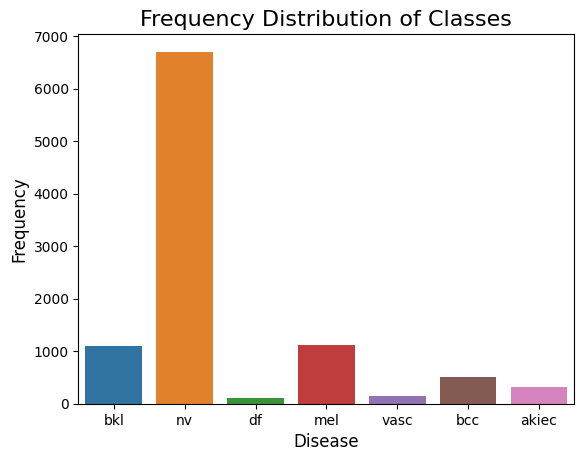

In [ ]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# Distribution of Disease over Gender

Text(0.5, 1.0, 'Gender of Patient')

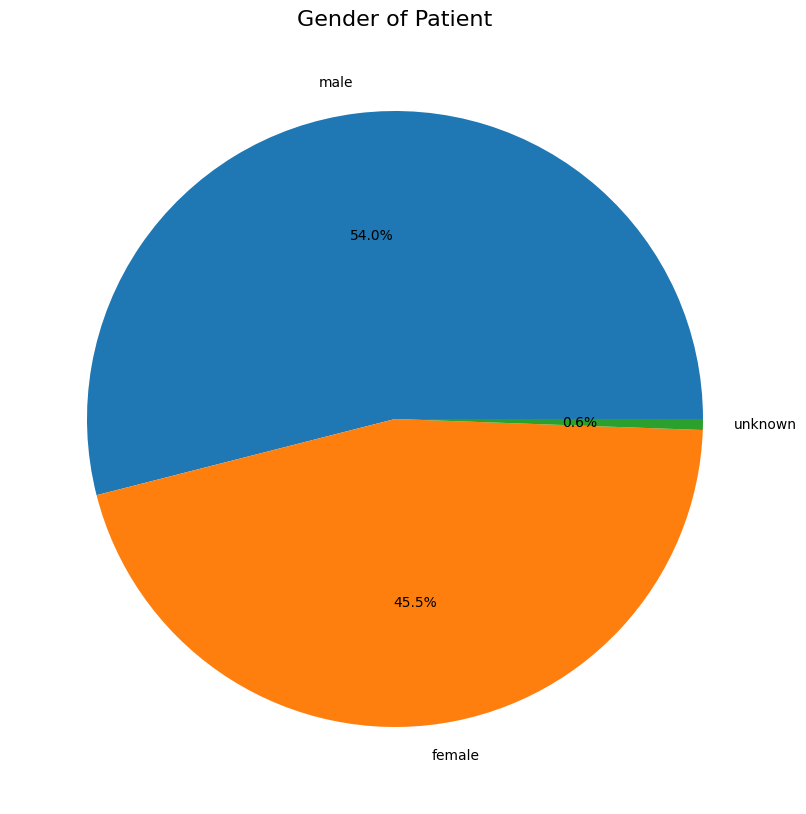

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

# Histogram of Age of Patients

Text(0.5, 1.0, 'Histogram of Age of Patients')

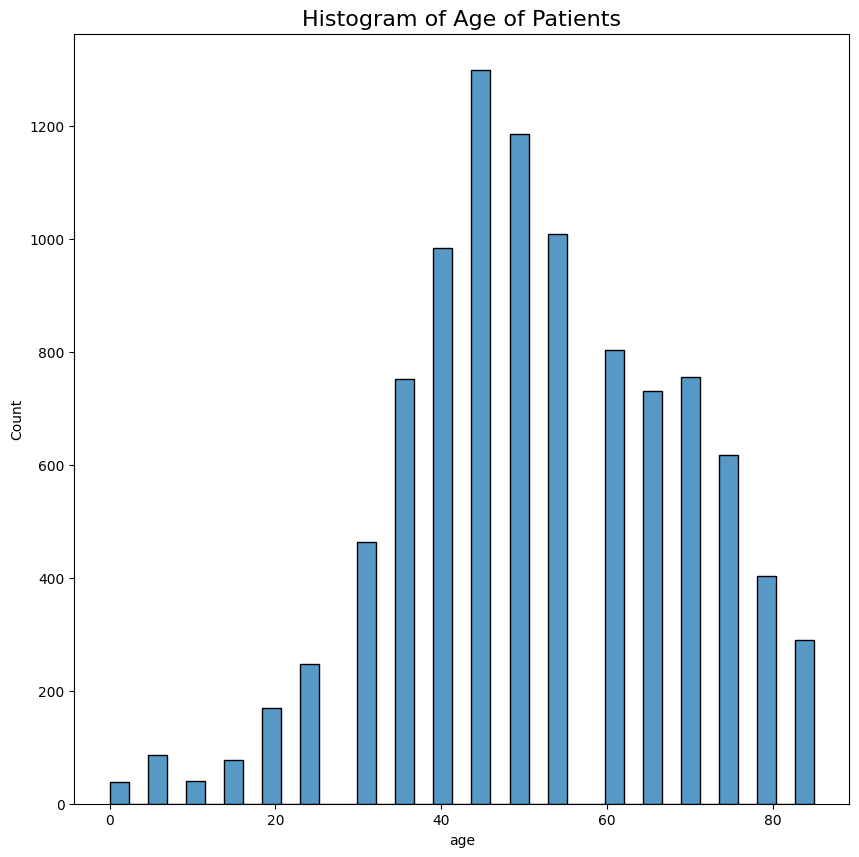

In [ ]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

# Location of disease over Gender

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

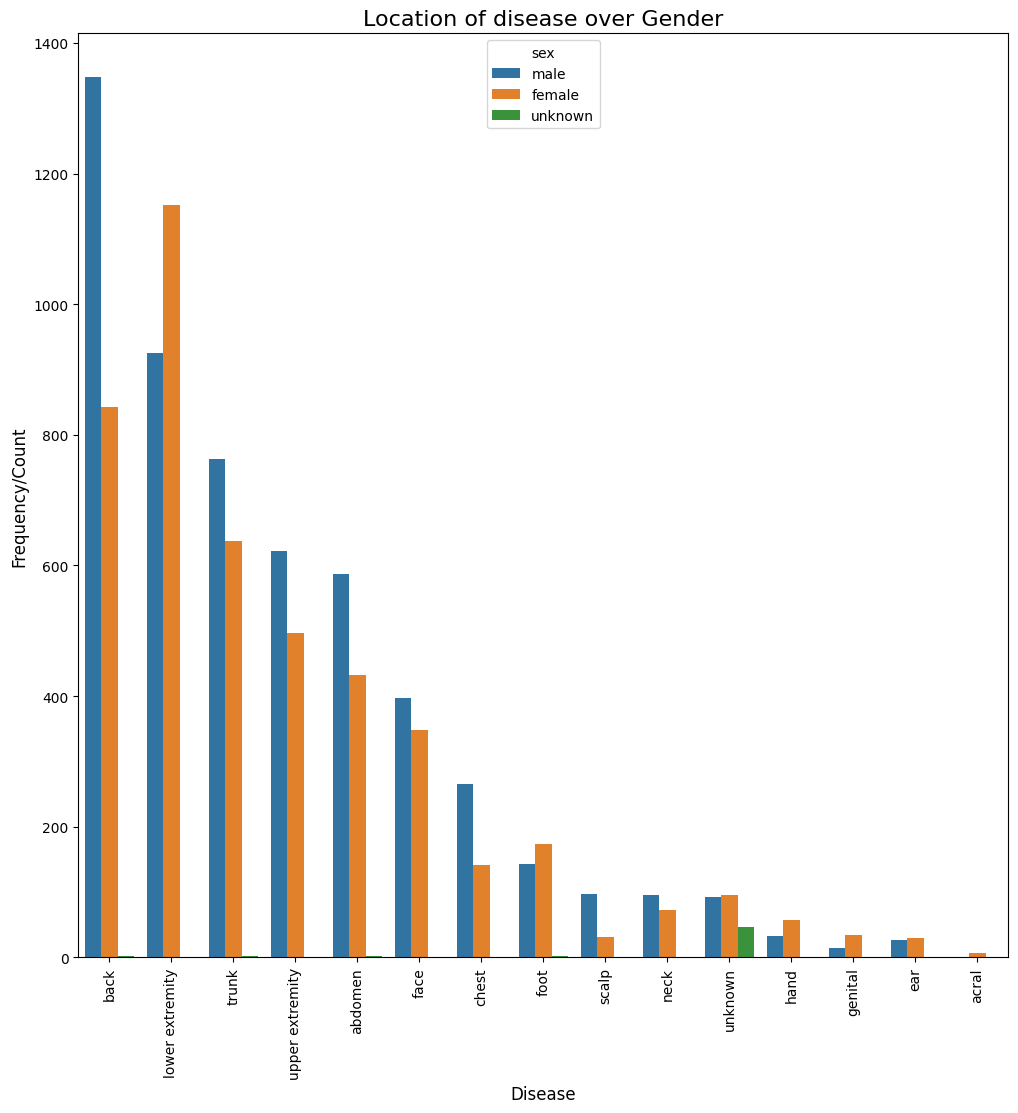

In [ ]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Oversampling
**To overcome class imbalance**

`You can remove the Oversampler by commenting out the cell below`

In [ ]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
x.shape

(46935, 3072)

In [ ]:
x = np.array(x).reshape(reshape)
print('Shape of X :',x.shape)


Shape of X : (46935, 32, 32, 3)


# Standardization and Splitting Data
`You can remove the standardization by commenting the line below`

In [ ]:
x = (x-np.mean(x))/np.std(x)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
X_train = np.array(X_train).reshape(reshape)
print('Shape of X :',X_train.shape)

Shape of X : (37548, 32, 32, 3)


In [ ]:
X_test.shape

(9387, 32, 32, 3)

# Model Training

In [ ]:
# Custom CNN Architecture

# model = Sequential()
# model.add(Conv2D(16, kernel_size = (3,3), input_shape = input_shape, activation = 'relu', padding = 'same'))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.summary()

## Change below cell to suit pretrained Model
`Change the below cell to your assigned pre-trained model`

`Note that each pretrained model might have it's recommended image size`

In [ ]:
# Using Pretrained Model

from tensorflow.keras.applications import nasnet
from tensorflow.keras.layers import GlobalAveragePooling2D

# Pretrained Model
base_model = nasnet.NASNetLarge(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
base_model,
GlobalAveragePooling2D(),
Dense(64, activation='relu'),
Dense(32, activation='relu'),
Dense(7, activation='softmax')
])

model.summary()

343610240/343610240 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 1, 1, 4032)        84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                258112    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 85,177,241
Trainable params: 260,423
Non-

In [ ]:
# Using Pretrained Model

# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D


# # Pretrained Model
# base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
# base_model.trainable = False

# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(7, activation='softmax')
# ])

# model.summary()

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 25,
                    callbacks=[callback])

Epoch 1/25
235/235 [==============================] - ETA: 0s - loss: 1.8475 - accuracy: 0.2187
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 481s 2s/step - loss: 1.8475 - accuracy: 0.2187 - val_loss: 1.8215 - val_accuracy: 0.2321
Epoch 2/25
235/235 [==============================] - ETA: 0s - loss: 1.7854 - accuracy: 0.2562
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 499s 2s/step - loss: 1.7854 - accuracy: 0.2562 - val_loss: 1.7628 - val_accuracy: 0.2724
Epoch 3/25
235/235 [==============================] - ETA: 0s - loss: 1.7449 - accuracy: 0.2771
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 500s 2s/step - loss: 1.7449 - accuracy: 0.2771 - val_loss: 1.7368 - val_accuracy: 0.2722
Epoch 4/25
235/235 [==============================] - ETA: 0s - loss: 1.7185 - accuracy: 0.2875
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 440s 2s/step - loss: 

In [ ]:
X_train.shape

(37548, 2352)

# Plot Accuracy and Loss

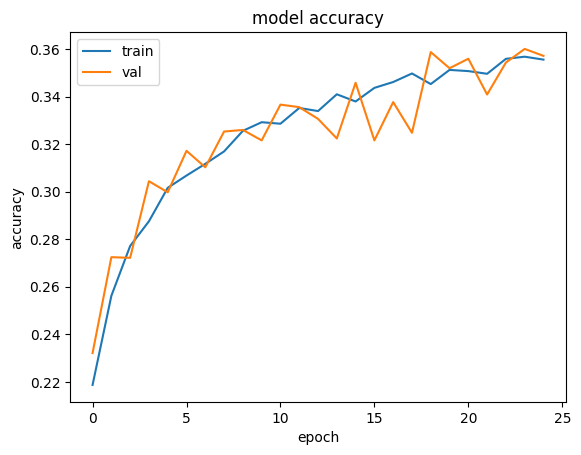

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

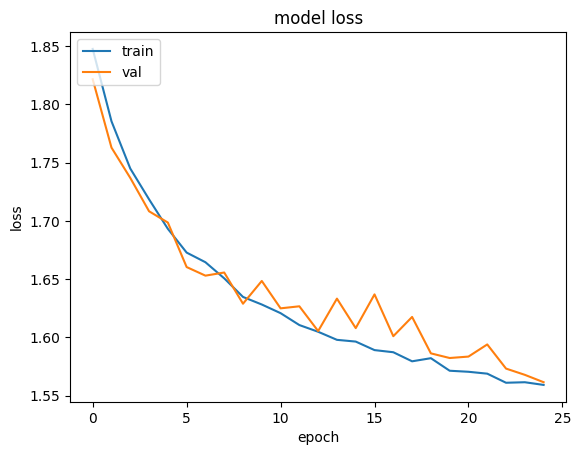

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save Model

In [ ]:
import tensorflow as tf

model.save('best_model.h5')
model.save_weights('best_model_weights.h5')

model = tf.keras.models.load_model('best_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("best_model1.tflite", "wb").write(tflite_model)

# Model Evaluation on Validation Set

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize = (10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


NameError: ignored

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 129s - loss: 1.5706 - accuracy: 0.3531 - 129s/epoch - 440ms/step


In [ ]:
classes = {k:v[0] for k,v in classes.items()}
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
confusion_mtx = confusion_matrix(Y_test, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes.values())

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
Y_pred = np.argmax(model.predict(X_test),axis=1)
print(classification_report(np.float32(Y_test), Y_pred.round()))
print('Classification Report')

# Model Evaluation on Test Set

In [ ]:
Y_testset = testset['label']
X_testset = testset.drop(columns = ['label'])

X_testset= np.array(X_testset).reshape(reshape)
print('Shape of X_testset :',X_testset.shape)

# Normalize the data
X_testset = (X_testset-np.mean(X_testset))/np.std(X_testset)

In [ ]:
loss, acc = model.evaluate(X_testset, Y_testset, verbose=2)

48/48 [==============================] - 21s 449ms/step


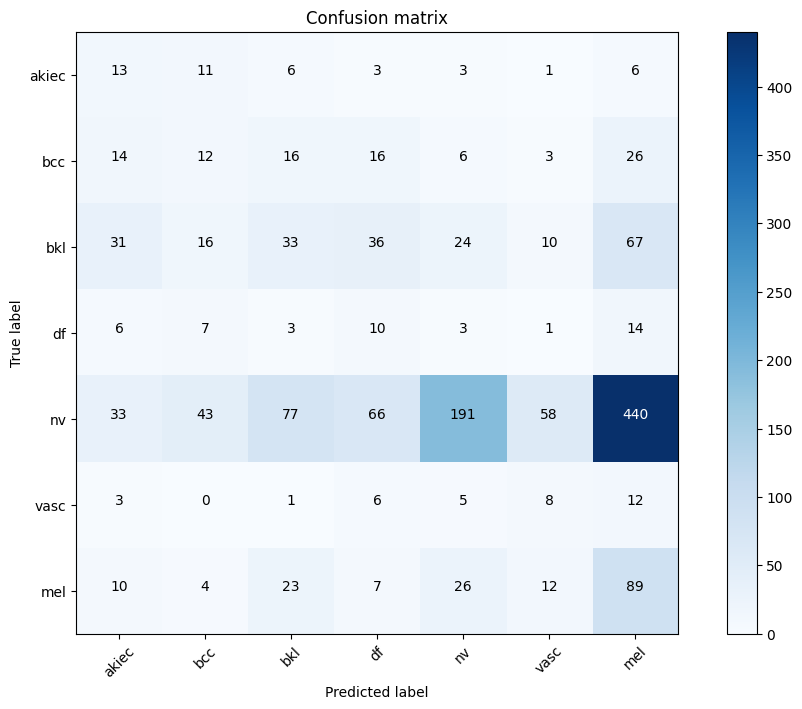

In [ ]:
Y_testset_pred = model.predict(X_testset)
Y_testset_pred_classes = np.argmax(Y_testset_pred,axis = 1)
confusion_mtx = confusion_matrix(Y_testset, Y_testset_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes.values())

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
Y_testset_pred = np.argmax(model.predict(X_testset),axis=1)
print(classification_report(np.float32(Y_testset), Y_testset_pred.round()))
print('Classification Report')

48/48 [==============================] - 21s 431ms/step
              precision    recall  f1-score   support

         0.0       0.12      0.30      0.17        43
         1.0       0.13      0.13      0.13        93
         2.0       0.21      0.15      0.18       217
         3.0       0.07      0.23      0.11        44
         4.0       0.74      0.21      0.33       908
         5.0       0.09      0.23      0.12        35
         6.0       0.14      0.52      0.22       171

    accuracy                           0.24      1511
   macro avg       0.21      0.25      0.18      1511
weighted avg       0.51      0.24      0.27      1511

Classification Report
